Characterizations of data in iDigBio suitible for text mining

In [35]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
# Load iDigBio Parquet
sqlContext = SQLContext(sc)
#idbdf = sqlContext.read.parquet("../data/idigbio/occurrence.txt.parquet")
idbdf = sqlContext.read.parquet("../data/idigbio-100k/occurrence.txt.parquet")
total_records = idbdf.count()
print(total_records)

99999


Let's start with the assumption that we know what fields are useful for looking for general features (we're not interested in parsing of taxonomic history or fields that are very specific to a single feature and require lots of domain knowlege to decode data representations.)

http://rs.tdwg.org/dwc/terms/dynamicProperties
http://rs.tdwg.org/dwc/terms/fieldNotes
http://portal.idigbio.org/terms/associateNotes
http://rs.tdwg.org/dwc/terms/occurrenceRemarks
http://rs.tdwg.org/dwc/terms/eventRemarks

Of these, dynamicProperties is best left for parsing. associateNotes is an iDigBio term that I'm not sure what it is. This leaves fieldNotes, occurrenceRemarks, and eventRemarks.

How many records have something in these fields?

In [9]:
# http://www.nodalpoint.com/unexpected-behavior-of-spark-dataframe-filter-method/
# Use SQL syntax here because column names suck
idbdf.registerTempTable("idbtable")
notes = sqlContext.sql("""
                       SELECT
                       *,
                       CONCAT(`http://rs.tdwg.org/dwc/terms/fieldNotes`, ' ',
                       `http://rs.tdwg.org/dwc/terms/occurrenceRemarks`, ' ',
                       `http://rs.tdwg.org/dwc/terms/eventRemarks`
                       ) as document
                       FROM idbtable WHERE 
                       `http://rs.tdwg.org/dwc/terms/fieldNotes` != '' OR
                       `http://rs.tdwg.org/dwc/terms/occurrenceRemarks` != '' OR 
                       `http://rs.tdwg.org/dwc/terms/eventRemarks` != ''
                       """)
notes_records = notes.count()
print(notes_records)
print(1.0 * notes_records/total_records * 100)
for r in notes.head(10):
    print(r['document'])


20745
20.7452074521
 SVL 43.0 mm, Total 112.0 mm, WT 1.1 gm.  Time constrained searches. 
 Additional data on card. 
 Additional data on card 
  1 of 2 collections made with field number WGS 67-42.
  flight intercept trap
  = RHR96-21; see field notes
 Flowers purple. 
 Additional data on card 
  flight intercept trap
 Habenaria hyperborea 


What are typical lengths of text to work with here? Histogram of length of the document texts

In [16]:
# make a Pandas data frame to work with, this is expensive-ish depending on data size, 
# perhaps we should cut back on the columns in the select statement and alias them to make
# life better? -- OOM's with full data set
notes_pd = notes.toPandas()

<class 'pandas.core.frame.DataFrame'>


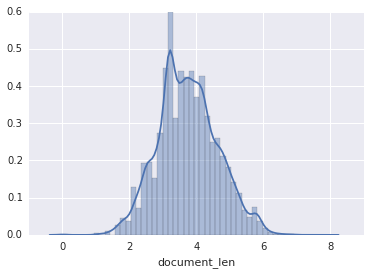

In [37]:
print(type(notes_pd))

# I guess there are some None's in the column...
def wow(r):
    if r['document'] is None:
        return 0
    else:
        return math.log(len(r['document']))
    
notes_pd['document_len'] = notes_pd.apply(lambda r: wow(r), axis=1) 
#print(notes_pd.head())
sns.distplot(notes_pd['document_len'])

In [44]:
# Really, I have ones that are 10k characters?
print(notes_pd.loc[notes_pd['document_len'] > 4].head()['document'])


0      SVL 43.0 mm, Total 112.0 mm, WT 1.1 gm.  Time...
27     Originally identified as Pseudacris maculata;...
30    ACC: 0; Group Number: 13; Preparation: 0 Alch,...
32     Tree 5 m tall.  Mature berries purple-black. ...
39     UNC-IMS 6205 originally contained lots from m...
Name: document, dtype: object
